# 2. Photometric redshift of galaxies
## 1b) 
The early work on photometric redshifts was done using linear regression. Design a regression estimator using either ridge, LASSO or linear regression to predict photometric redshifts, make sure to justify all the choises you make. Use the whole of file A for training and aim to obtain E($\theta$) < 0.01 as training error

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io.votable import parse_single_table
from astroML.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
import seaborn as sns
import pandas as pd

%matplotlib inline

In [5]:
# Load the data

root = "/disks/strw9/stoop/DBDM/DDM2017-master/FinalProject/Final-Project-DBDM/"

tableA = parse_single_table(root + "PhotoZFileA.vot")
tableB = parse_single_table(root + "PhotoZFileB.vot")

Xa = np.vstack((tableA.array['mag_r'], tableA.array['u-g'], tableA.array['g-r'], tableA.array['r-i'], tableA.array['i-z'])).T
ya = tableA.array['z_spec']

Xb = np.vstack((tableB.array['mag_r'], tableB.array['u-g'], tableB.array['g-r'], tableB.array['r-i'], tableB.array['i-z'])).T
yb = tableB.array['z_spec']


In [6]:
# The properties of the data
print "Train data\n---------"
print "# observations ", len(ya)
print "Mean ", np.mean(ya), "Std ", np.std(ya)
print "Min: ", np.min(ya), "Max: ", np.max(ya)

print "\nTest data\n---------"
print "# observations ", len(yb)
print "Mean ", np.mean(yb), "Std ", np.std(yb)
print "Min: ", np.min(yb), "Max: ", np.max(yb)

Train data
---------
# observations  74309
Mean  0.322559287704 Std  0.0881063613686
Min:  0.010716 Max:  0.939824

Test data
---------
# observations  74557
Mean  0.323083799509 Std  0.0877897016025
Min:  3.6e-05 Max:  0.8897


In [7]:
# Transform the data to only get magnitudes

colnames = ['r', 'g', 'i', 'u', 'z']

ma_r = tableA.array['mag_r']
ma_g = tableA.array['g-r']   +  ma_r
ma_i = ma_r                  -  tableA.array['r-i']
ma_u = tableA.array['u-g']   +  ma_g
ma_z = ma_i                  -  tableA.array['i-z']

mb_r = tableB.array['mag_r']
mb_g = tableB.array['g-r']   +  mb_r
mb_i = mb_r                  -  tableB.array['r-i']
mb_u = tableB.array['u-g']   +  mb_g
mb_z = mb_i                  -  tableB.array['i-z']

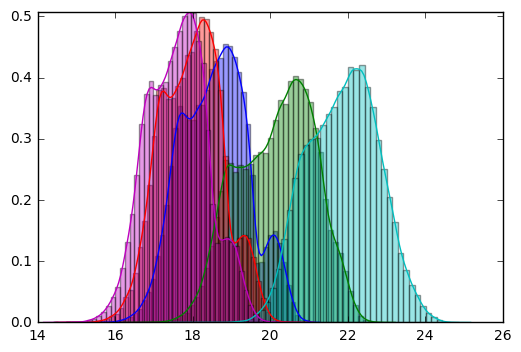

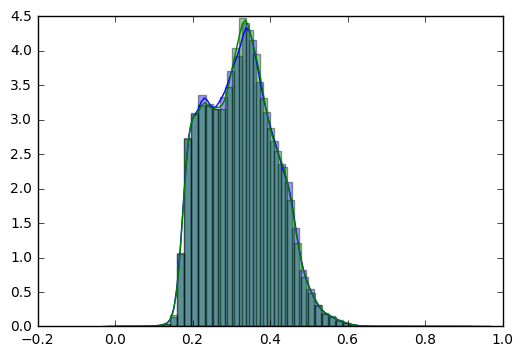

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7eeaab5c10>, None)

In [176]:
# What is the distribution of the data

# Colours
sns.distplot(ma_r)
sns.distplot(ma_g)
sns.distplot(ma_i)
sns.distplot(ma_u)
sns.distplot(ma_z), plt.show()

# Redshift
sns.distplot(ya)
sns.distplot(yb), plt.show()

## Try different models to work with linear regression


### Model 1
$z = \theta_0 + \sum_{i = 1,.., 5} \theta_i M_i$

In [79]:
# Get the data in the right form

Xmag_a = np.vstack((ma_r, ma_g, ma_i, ma_u, ma_z)).T
ya = tableA.array['z_spec']
Xmag_b = np.vstack((mb_r, mb_g, mb_i, mb_u, mb_z)).T
yb = tableB.array['z_spec']

In [8]:
def E(y_pred, y):
    err = np.median(np.abs( (y.astype(float) - y_pred.astype(float)) / (1 + y.astype(float))))
    return err

def Predict( X, y, Xtest, ytest, model = 'Linear', dy = [0]):
    """Predicts the error margin of the fitted linear model
    Input 
    -----
    X     = The data to train the model on (n_samples x n_features)
    y     = The label of the data (n_samples)
    Xtest = The test data for which to test the model on (n_samples x n_features)
    ytest = The correct output for the values found in Xtest (n_samples)
    model = Which linear model to choose. Linear, Lasso or Ridge can be chosen
    dy    = The weights to give to the y data. 
    
    Output
    ------
    e_train = The error on the training data using function E
    e_test  = The error on the test data using function E
    coeff   = The coefficience of the model."""
    
    #Choose model
    if model == 'Linear':
        m = LinearRegression(fit_intercept=True)
    if model == 'Ridge':
        m = Ridge(alpha=0.05,fit_intercept=True, normalize=True)
    if model == 'Lasso':
        m = Lasso(alpha=0.05,fit_intercept=True, normalize=True)
    
    #Take the error into account
    if len(dy) > 1:
        res = m.fit(X, y, dy)
    else:
        res = m.fit(X,y)
    
    # Predict for X and Xtest
    ypred_train = res.predict(X)
    ypred_test  = res.predict(Xtest)
    
    # Get error
    e_train = E(ypred_train, y)
    e_test  = E(ypred_test, ytest)
    
    # Calculate the coefficience
    if model == 'Linear':
        coeff = res.coef_
    else:
        coeff = [res.intercept_]
        [coeff.append(c) for c in res.coef_]
        
    return e_train, e_test, coeff

In [23]:
# Make the models and calculate the error for Linear, Lasso and Ridge models

Etrain, Etest, coeff = Predict(Xmag_a, ya, Xmag_b, yb, model = 'Linear')
print "Linear Regression\n------------\nz = {0:0.4f} + {1:0.4f}mag_r + {2:0.4f}mag_g + {3:0.4f}mag_i + {4:0.4f}mag_u + {5:0.4f}mag_z".format(coeff[0], coeff[1], coeff[2], coeff[3], coeff[4], coeff[5])
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Etrain, Etest, coeff = Predict(Xmag_a, ya, Xmag_b, yb, model = 'Lasso')
print "Lasso Regression\n------------\nz = {0:0.4f} + {1:0.4f}mag_r + {2:0.4f}mag_g + {3:0.4f}mag_i + {4:0.4f}mag_u + {5:0.4f}mag_z".format(coeff[0], coeff[1], coeff[2], coeff[3], coeff[4], coeff[5]
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Etrain, Etest, coeff = Predict(Xmag_a, ya, Xmag_b, yb, model = 'Ridge')
print "Ridge Regression\n------------\nz = {0:0.4f} + {1:0.4f}mag_r + {2:0.4f}mag_g + {3:0.4f}mag_i + {4:0.4f}mag_u + {5:0.4f}mag_z".format(coeff[0], coeff[1], coeff[2], coeff[3], coeff[4], coeff[5]
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Linear Regression
------------
z = -0.7834mag_r + 0.3723mag_g + 0.0960mag_i + -0.3946mag_u + -0.0127mag_z
Training Error = 0.0146
Test Error = 0.0146

Lasso Regression
------------
z = 0.3226mag_r + 0.0000mag_g + 0.0000mag_i + 0.0000mag_u + 0.0000mag_z
Training Error = 0.0503
Test Error = 0.0499

Ridge Regression
------------
z = -1.2477mag_r + 0.0327mag_g + 0.0517mag_i + -0.0025mag_u + 0.0088mag_z
Training Error = 0.0196
Test Error = 0.0198



### Model 2
$z = \theta_0 + \sum_{i = 1,.., 5} \theta_i M_i + \sum_{i = 1,.., 5; j = 1, .., 5}\theta_{i,j}M_i M_j$

Based on:
Connolly, A. J., Csabai, I., Szalay, A. S., Koo, D. C., Kron, R. G., and Munn, J. A.: 1995a, Astron. J. 110, 2655 
https://arxiv.org/pdf/astro-ph/9508100.pdf

In [11]:
# Get the X data in the form of the model

Xa2 = []
colnames2_1 = []
for i, m1 in enumerate([ma_r, ma_g, ma_i, ma_u, ma_z]):
    Xa2.append(m1)
    colnames2_1.append(colnames[i])
    for j, m2 in enumerate([ma_r, ma_g, ma_i, ma_u, ma_z]):
        if not colnames[j] + colnames[i] in colnames2_1:
            Xa2.append(m1*m2)
            colnames2_1.append(colnames[i] + colnames[j])

Xa2 = np.array(Xa2).T

Xb2 = []
colnames2_2 = []
for i, m1 in enumerate([mb_r, mb_g, mb_i, mb_u, mb_z]):
    Xb2.append(m1)
    colnames2_2.append(colnames[i])
    for j, m2 in enumerate([mb_r, mb_g, mb_i, mb_u, mb_z]):
        if not colnames[j] + colnames[i] in colnames2_2:
            Xb2.append(m1*m2)
            colnames2_2.append(colnames[i] + colnames[j])

Xb2 = np.array(Xb2).T

In [18]:
# Make the models and calculate the error for Linear, Lasso and Ridge models

Etrain, Etest, coeff = Predict(Xa2, ya, Xb2, yb, model = 'Linear')
print "Linear Regression\n------------\n", coeff
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)



Etrain, Etest, coeff = Predict(Xa2, ya, Xb2, yb, model = 'Lasso')
print "Lasso Regression\n------------\n", coeff
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Etrain, Etest, coeff = Predict(Xa2, ya, Xb2, yb, model = 'Ridge')
print "Ridge Regression\n------------\n", coeff
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

['r', 'rr', 'rg', 'ri', 'ru', 'rz', 'g', 'gg', 'gi', 'gu', 'gz', 'i', 'ii', 'iu', 'iz', 'u', 'uu', 'uz', 'z', 'zz']


/software/local/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Linear Regression
------------
[ 0.04210856 -1.96809491  1.93190757 -0.56554235 -3.66885038 -0.05376648
  0.50558644  1.26952212 -0.00785072  0.78333432  0.05073151 -0.31054087
 -0.56212847  1.54514996 -0.06424578 -0.08635977 -0.09148509  0.01429348
  0.03324717  1.29346618 -0.10274457]
Training Error = 0.0128
Test Error = 0.0127

Lasso Regression
------------
[0.32255928770404657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Training Error = 0.0503
Test Error = 0.0499

Ridge Regression
------------
[-0.54992402455781475, 0.016951444608320394, 0.00051242188827745809, 0.00060848066612436118, 0.00013650073904720368, 0.00022391455729369212, 6.2496479728776092e-05, 0.02653083019344056, 0.00066952330193264316, 0.00028887969371305539, 0.00035018120017702017, 0.00022547662177926841, -0.01275987044870029, -0.00031054888477135818, -0.00016911695318557688, -0.00039859211411081457, -0.0016883397579742475, -3.5259075633600324e-05, -0.000247557

### Model 3
$z = \theta_0 + \sum_{i = 1,.., 5} \theta_i M_i + \sum_{i = 1,.., 5} \theta_i M_i^2$

In [218]:
# Get the X data in the form of the model

Xa3 = []
colnames3_1 = []
for i, m1 in enumerate([ma_r, ma_g, ma_i, ma_u, ma_z]):
    Xa3.append(m1)
    colnames3_1.append(colnames[i])
    for j, m2 in enumerate([ma_r, ma_g, ma_i, ma_u, ma_z]):
        if i == j:
            Xa3.append(m1*m2)
            colnames3_1.append(colnames[i] + colnames[j])

Xa3 = np.array(Xa3).T

Xb3 = []
colnames3_2 = []
for i, m1 in enumerate([mb_r, mb_g, mb_i, mb_u, mb_z]):
    Xb3.append(m1)
    colnames3_2.append(colnames[i])
    for j, m2 in enumerate([mb_r, mb_g, mb_i, mb_u, mb_z]):
        if i == j:
            Xb3.append(m1*m2)
            colnames3_2.append(colnames[i] + colnames[j])

Xb3 = np.array(Xb3).T

In [219]:
# Make the models and calculate the error for Linear, Lasso and Ridge models

Etrain, Etest, coeff = Predict(Xa3, ya, Xb3, yb, model = 'Linear')
print "Linear Regression\n------------\n", coeff
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Etrain, Etest, coeff = Predict(Xa3, ya, Xb3, yb, model = 'Lasso')
print "Lasso Regression\n------------\n", coeff
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Etrain, Etest, coeff = Predict(Xa3, ya, Xb3, yb, model = 'Ridge')
print "Ridge Regression\n------------\n", coeff
print "Training Error = {0:0.4f}\nTest Error = {1:0.4f}\n".format(Etrain, Etest)

Linear Regression
------------
[  7.37452456e-01  -3.21821115e+00   9.25991643e-02   1.91372569e+00
  -4.36967858e-02   2.29894104e-01  -1.50337856e-02  -9.49348710e-02
   1.84281326e-03   9.87459584e-01  -2.86212739e-02]
Training Error = 0.0132
Test Error = 0.0133

Lasso Regression
------------
[0.32255928770404657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Training Error = 0.0503
Test Error = 0.0499

Ridge Regression
------------
[-0.78977558517745705, 0.02248667139297196, 0.00066128309954700088, 0.035322099984116659, 0.00089144836177157437, -0.0092611256764823131, -0.00021398069164547639, 0.0017039384789302328, 4.3120758284574048e-05, -0.016776087028760184, -0.00043679277694993443]
Training Error = 0.0185
Test Error = 0.0186



### PCA with Model 1

In [222]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

<Container object of 6 artists>

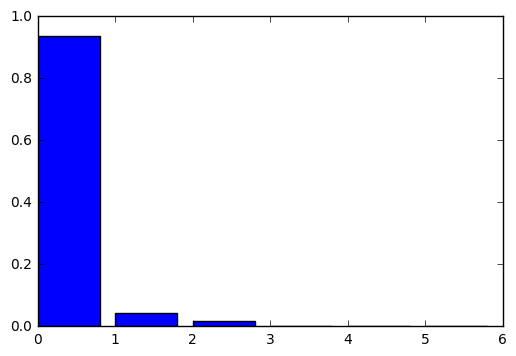

In [224]:
Xa1 = np.vstack((Xmag_a.T, ya)).T
Xb1 = np.vstack((Xmag_b.T, yb)).T

scl = StandardScaler()
Xs1  = scl.fit_transform(Xa1)
pca1 = PCA(whiten=False, n_components = 6)
pca1.fit(Xs1)
plt.bar(range(len(pca1.explained_variance_ratio_)), pca1.explained_variance_ratio_)

In [226]:
e_train, e_test = [], []

scl = StandardScaler()
Xs1 = scl.fit_transform(Xa1)
for n in range(1, 6):
    pca     = PCA(whiten=False, n_components = n)
    Xtrans  = pca.fit_transform(Xs1)
    Xp      = pca.inverse_transform(Xtrans)
    Xp_orig = scl.inverse_transform(Xp)
    
    print "{0} components\n--------".format(n)
    _, Etrain, coeff = Predict(Xp_orig[:,:5], Xp_orig[:,5], Xa1[:,:5], Xa1[:,5])
    _, Etest, coeff  = Predict(Xp_orig[:,:5], Xp_orig[:,5], Xb1[:,:5], Xb1[:,5])
    e_train.append(Etrain)
    e_test.append(Etest)
    print "Training E = {0:.03f}".format(Etrain)
    print "Test E = {0:.03f}".format(Etest)



1 components
--------
Training E = 0.049
Test E = 0.049
2 components
--------
Training E = 0.103
Test E = 0.103
3 components
--------
Training E = 0.042
Test E = 0.042
4 components
--------
Training E = 0.186
Test E = 0.187
5 components
--------
Training E = 0.047
Test E = 0.048


Best fit: 
 Training Error = 0.042
 Test Error = 0.042


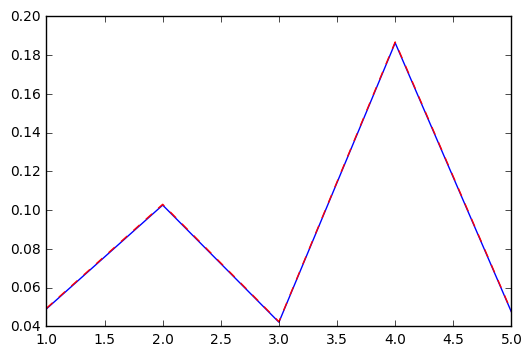

In [228]:
print "Best fit: \n Training Error = {0:0.3f}\n Test Error = {1:0.3f}".format( e_train[np.argmin(e_test)], np.min(e_test))
plt.plot(range(1,6), e_train)
plt.plot(range(1,6), e_test, '--', c='red' )

### PCA with Model 2

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
Xa2_new = np.vstack((Xa2.T, ya)).T
Xb2_new = np.vstack((Xb2.T, yb)).T

In [13]:
# Perform PCA for different number of components

e_train_st, e_test_st = [], []

scl = StandardScaler()
Xs2 = scl.fit_transform(Xa2_new)
for n in range(1, 21):
    pca     = PCA(whiten=False, n_components = n)
    Xtrans  = pca.fit_transform(Xs2)
    Xp      = pca.inverse_transform(Xtrans)
    Xp_orig = scl.inverse_transform(Xp)
    
    print "{0} components\n--------".format(n)
    _, Etrain, coeff = Predict(Xp_orig[:,:20], Xp_orig[:,20], Xa2_new[:,:20], Xa2_new[:,20])
    _, Etest, coeff  = Predict(Xp_orig[:,:20], Xp_orig[:,20], Xb2_new[:,:20], Xb2_new[:,20])
    e_train_st.append(Etrain)
    e_test_st.append(Etest)
    print "Training E = {0:.03f}".format(Etrain)
    print "Test E = {0:.03f}".format(Etest)



1 components
--------


/software/local/lib64/python2.7/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Training E = 0.041
Test E = 0.041
2 components
--------
Training E = 0.026
Test E = 0.026
3 components
--------
Training E = 0.031
Test E = 0.031
4 components
--------
Training E = 0.044
Test E = 0.044
5 components
--------
Training E = 0.047
Test E = 0.048
6 components
--------
Training E = 0.076
Test E = 0.076
7 components
--------
Training E = 0.063
Test E = 0.064
8 components
--------
Training E = 0.083
Test E = 0.083
9 components
--------
Training E = 0.105
Test E = 0.105
10 components
--------
Training E = 0.091
Test E = 0.091
11 components
--------
Training E = 0.163
Test E = 0.162
12 components
--------
Training E = 0.147
Test E = 0.147
13 components
--------
Training E = 0.109
Test E = 0.109
14 components
--------
Training E = 0.121
Test E = 0.122
15 components
--------
Training E = 0.088
Test E = 0.088
16 components
--------
Training E = 0.092
Test E = 0.092
17 components
--------
Training E = 0.298
Test E = 0.300
18 components
--------
Training E = 0.053
Test E = 0.054
19 co

Best fit: 
 Training Error = 0.026
 Test Error = 0.026


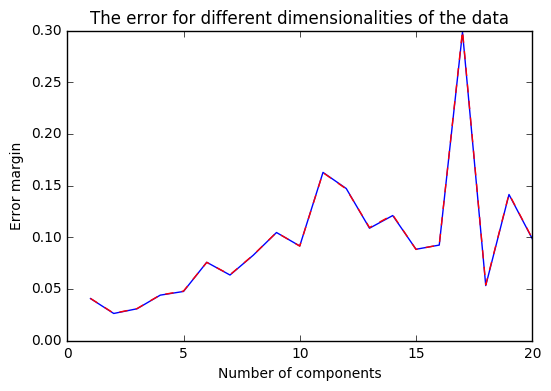

In [17]:
# Plot the results

print "Best fit: \n Training Error = {0:0.3f}\n Test Error = {1:0.3f}".format( e_train_st[np.argmin(e_test_st)], np.min(e_test_st))
plt.plot(range(1,21), e_train_st, label='Training')
plt.plot(range(1,21), e_test_st, '--', c='red', label='Test' )
plt.xlabel('Number of components')
plt.ylabel("Error margin")
plt.title("The error for different dimensionalities of the data")

1 components
--------
Training E = 35608290.763
Test E = 35626364.184

2 components
--------
Training E = 13804728.029
Test E = 13746153.309

3 components
--------
Training E = 1799993.838
Test E = 1793816.088

4 components
--------
Training E = 24247753.401
Test E = 24344888.261

5 components
--------
Training E = 504672.081
Test E = 504321.409

6 components
--------
Training E = 104591.888
Test E = 104799.451

7 components
--------
Training E = 98351.963
Test E = 98479.169

8 components
--------
Training E = 177700.348
Test E = 177610.558

9 components
--------
Training E = 20759.972
Test E = 20732.858

10 components
--------
Training E = 5045.886
Test E = 5057.027

11 components
--------
Training E = 1397.642
Test E = 1391.096

12 components
--------
Training E = 1883.459
Test E = 1879.037

13 components
--------
Training E = 683.479
Test E = 684.279

14 components
--------
Training E = 568.936
Test E = 577.824

15 components
--------
Training E = 69.475
Test E = 70.557

16 componen

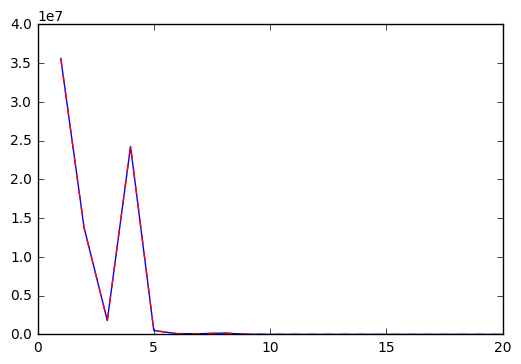

In [18]:
# PCA without standardising the data

e_train, e_test = [], []

for n in range(1, 21):
    pca    = PCA(whiten=False, n_components = n)
    Xtrans = pca.fit_transform(Xa2_new)
    Xp     = pca.inverse_transform(Xtrans)
    
    print "{0} components\n--------".format(n)
    _, Etrain, coeff = Predict(Xp[:,:20], Xa2_new[:,20], Xa2_new[:,:20], Xa2_new[:,20])
    _, Etest, coeff  = Predict(Xp[:,:20], Xa2_new[:,20], Xb2_new[:,:20], Xb2_new[:,20])
    e_train.append(Etrain)
    e_test.append(Etest)
    print "Training E = {0:.03f}".format(Etrain)
    print "Test E = {0:.03f}\n".format(Etest)

print "\nBest fit: \n Training Error = {0:0.3f}\n Test Error = {1:0.3f}".format( e_train[np.argmin(e_test)], np.min(e_test))
plt.plot(range(1,21), e_train)
plt.plot(range(1,21), e_test, '--', c='red' )

## Result:
--------------

Best fit found for Model 2 with Linear Regression with coefficience:

[ 0.04210856 -1.96809491  1.93190757 -0.56554235 -3.66885038 -0.05376648
  0.50558644  1.26952212 -0.00785072  0.78333432  0.05073151 -0.31054087
 -0.56212847  1.54514996 -0.06424578 -0.08635977 -0.09148509  0.01429348
  0.03324717  1.29346618 -0.10274457]

for the columns: ['r','rr', 'rg', 'ri', 'ru', 'rz', 'g', 'gg', 'gi', 'gu', 'gz', 'i', 'ii', 'iu', 'iz', 'u', 'uu', 'uz', 'z', 'zz']

Training Error = 0.0128

Test Error = 0.0127

## 1d)
Implement a photo-z estimator using the method of your choice from any of the regression methods
discussed in the course, excluding the linear regression methods, e.g. k-nearest neighbours,
random forests, neural networks, boosting methods, but aim to get a lower generalisation error
than your method derived in problem b.

In [80]:
dfA = pd.DataFrame(Xmag_a, columns = colnames)
dfB = pd.DataFrame(Xmag_b, columns = colnames)

### Neural Network

In [156]:
from sklearn.neural_network import MLPRegressor as nn

In [157]:
# put everything in the correct data type version

X_train = [tuple(x) for x in dfA.to_records(index=False)]
y_train = list(ya)

X_test  = [tuple(x) for x in dfB.to_records(index=False)]
y_test  = list(yb)

In [175]:
# Try a 3 layerd network

lay2 = np.arange(1, 20, 1)
lay3 = np.arange(1, 20, 1)

best_e = np.inf
e_test = []
e_train = []


for i, l2 in enumerate(lay2):
    e_test_loc = []
    e_train_loc = []
    for m, l3 in enumerate(lay3):
        print "layers:",l2,l3, "\n-------------------"

        mlp = nn(hidden_layer_sizes=(5, l2, l3, 1))
        mlp.fit(X_train, y_train)
        
        pred_train = mlp.predict(X_train)
        pred_test  = mlp.predict(X_test)
        
        Etrain = E(pred_train, ya) 
        Etest  = E(pred_test, yb) 
        
        print " Train E  = {}".format(Etrain)
        print " Test E   = {}\n".format(Etest)
        
        if Etest < best_e:
            params = [l2, l3]
            best_e = Etrain
            best_mlp = mlp

print "Beste value found: ", best_e 
print "lay2 = {0}, lay3 = {1}".format(params[0], params[1])

layers: 1 1 
-------------------
 Train E  = 0.0503773392646
 Test E = 0.0498620349084

layers: 1 2 
-------------------
 Train E  = 0.0503252869588
 Test E = 0.0498868812021

layers: 1 3 
-------------------
 Train E  = 0.0503740678018
 Test E = 0.049862873352

layers: 1 4 
-------------------
 Train E  = 0.0503035842838
 Test E = 0.049860978475

layers: 1 5 
-------------------
 Train E  = 0.0503450186956
 Test E = 0.0498810501166

layers: 1 6 
-------------------
 Train E  = 0.0175754239944
 Test E = 0.0177270428387

layers: 1 7 
-------------------
 Train E  = 0.0220760730705
 Test E = 0.0222582647672

layers: 1 8 
-------------------
 Train E  = 0.050345867265
 Test E = 0.0498788967819

layers: 1 9 
-------------------
 Train E  = 0.0219481294363
 Test E = 0.0219670853918

layers: 1 10 
-------------------
 Train E  = 0.0503173265404
 Test E = 0.0498880225904

layers: 1 11 
-------------------
 Train E  = 0.0503012603984
 Test E = 0.0498517823265

layers: 1 12 
-------------------

In [178]:
# Try a 3 layerd network

lay2 = np.arange(1, 20, 1)
lay3 = np.arange(1, 20, 1)
lay4 = np.arange(1, 20, 1)

best_e = np.inf

e_test = []
e_train = []


for i, l2 in enumerate(lay2):
    e_test_loc = []
    e_train_loc = []
    for m, l3 in enumerate(lay3):
        for k, l4 in enumerate(lay4):
            print "layers:",l2,l3,l4, "\n-------------------"

            mlp = nn(hidden_layer_sizes=(5, l2, l3, l4, 1))
            mlp.fit(X_train, y_train)

            pred_train = mlp.predict(X_train)
            pred_test  = mlp.predict(X_test)

            Etrain = E(pred_train, ya) 
            Etest  = E(pred_test, yb) 

            print " Train E  = {}".format(Etrain)
            print " Test E   = {}\n".format(Etest)

            if Etest < best_e:
                params = [l2, l3, l4]
                best_e = Etrain
                best_mlp = mlp

print "Beste value found: ", best_e 
print "lay2 = {0}, lay3 = {1}, lay4 = {2}".format(params[0], params[1], params[2])

layers: 1 1 1 
-------------------
 Train E  = 0.0503437655423
 Test E = 0.0498687252768

layers: 1 1 2 
-------------------
 Train E  = 0.0502972702711
 Test E = 0.0498539390724

layers: 1 1 3 
-------------------
 Train E  = 0.0504054184163
 Test E = 0.0498586080296

layers: 1 1 4 
-------------------
 Train E  = 0.0503008294988
 Test E = 0.0498515911901

layers: 1 1 5 
-------------------
 Train E  = 0.0503171566314
 Test E = 0.049888084085

layers: 1 1 6 
-------------------
 Train E  = 0.0503420674509
 Test E = 0.0498678756767

layers: 1 1 7 
-------------------
 Train E  = 0.0502894876499
 Test E = 0.0498296970832

layers: 1 1 8 
-------------------
 Train E  = 0.0503274250454
 Test E = 0.0498843205025

layers: 1 1 9 
-------------------
 Train E  = 0.0506170348721
 Test E = 0.0499591796579

layers: 1 1 10 
-------------------
 Train E  = 0.0503421397568
 Test E = 0.0498735857664

layers: 1 1 11 
-------------------
 Train E  = 0.0503455177239
 Test E = 0.049873326729

layers: 1 

NameError: name 'param' is not defined

In [183]:
print "lay2 = {0}, lay3 = {1}, lay4 = {2}".format(params[0], params[1], params[2])

lay2 = 5, lay3 = 3, lay4 = 13


### k-nearest neighbours regression:

In [190]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

def knn_regress(X, y, x_pred=None, k=5, alg = 'auto', boost=False):
    if boost:
        neigh = AdaBoostRegressor(KNeighborsRegressor(n_neighbors=k, algorithm = alg), n_estimators = 5)
    else:
        neigh = KNeighborsRegressor(n_neighbors=k, algorithm = alg)
    
    neigh.fit(X,y)
    
    y_hat = []
    for x in x_pred:
        y_hat.append(neigh.predict(x))
    
    return y_hat
    

In [184]:
e_train, e_test = [], []
#without boost
for k in range(1,50):
    print k, "\n-------"
    y_pred = knn_regress(dfA, ya, x_pred=[dfA, dfB], k=k, alg = 'ball_tree')
    e_train.append(E(y_pred[0], ya))
    e_test.append(E(y_pred[1], yb))
    print "Train Error = {}".format(E(y_pred[0], ya))
    print "Test Error  = {}".format(E(y_pred[1], yb))

print "Best k-nearest neighbours regression Fit\n---------------------\n Train Error = {0:.03f}\n Test Error = {1:.03f}".format(e_train[np.argmin(e_test)], np.min(e_test))


1 
-------
2 
-------
3 
-------
4 
-------
5 
-------
6 
-------
7 
-------
8 
-------
9 
-------
10 
-------
11 
-------
12 
-------
13 
-------
14 
-------
15 
-------
16 
-------
17 
-------
18 
-------
19 
-------
20 
-------
21 
-------
22 
-------
23 
-------
24 
-------
25 
-------
26 
-------
27 
-------
28 
-------
29 
-------
30 
-------
31 
-------
32 
-------
33 
-------
34 
-------
35 
-------
36 
-------
37 
-------
38 
-------
39 
-------
40 
-------
41 
-------
42 
-------
43 
-------
44 
-------
45 
-------
46 
-------
47 
-------
48 
-------
49 
-------
Best k-nearest neighbours regression Fit
---------------------
 Train Error = 0.012
 Test Error = 0.013


In [192]:
e_train_b, e_test_b = [], []
#with boost
for k in range(1,50):
    print k, "\n-------"
    y_pred = knn_regress(dfA, ya, x_pred=[dfA, dfB], k=k, alg = 'ball_tree', boost=True)
    e_train_b.append(E(y_pred[0], ya))
    e_test_b.append(E(y_pred[1], yb))
    print "Train Error = {}".format(E(y_pred[0], ya))
    print "Test Error  = {}".format(E(y_pred[1], yb))

print "Best k-nearest neighbours regression Fit\n---------------------\n Train Error = {0:.03f}\n Test Error = {1:.03f}".format(e_train_b[np.argmin(e_test_b)], np.min(e_test_b))


1 
-------
Train Error = 0.0
Test Error  = 0.0164182253104
2 
-------
Train Error = 0.00582426432628
Test Error  = 0.0147445497327
3 
-------
Train Error = 0.00897621364117
Test Error  = 0.0141370619702
4 
-------
Train Error = 0.0103381728812
Test Error  = 0.0138979408601
5 
-------
Train Error = 0.0109913732067
Test Error  = 0.013691746468
6 
-------
Train Error = 0.0114802393286
Test Error  = 0.0136453634057
7 
-------
Train Error = 0.0116562771886
Test Error  = 0.0134874374341
8 
-------
Train Error = 0.0118675172029
Test Error  = 0.01340244781
9 
-------
Train Error = 0.0120463659269
Test Error  = 0.0133701736697
10 
-------
Train Error = 0.0121521817541
Test Error  = 0.0133468814626
11 
-------
Train Error = 0.0121826888144
Test Error  = 0.013313768213
12 
-------
Train Error = 0.01223329785
Test Error  = 0.0132387703266
13 
-------
Train Error = 0.0123268257848
Test Error  = 0.0132610550257
14 
-------
Train Error = 0.0123600958408
Test Error  = 0.0131986631156
15 
-------
Train

KeyboardInterrupt: 

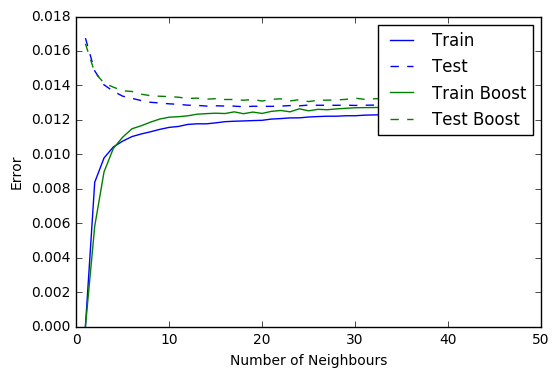

In [193]:
# Plot the results

plt.plot(range(1,50), e_train, '-', c = 'blue', label='Train')
plt.plot(range(1,50), e_test, '--', c = 'blue', label='Test')

plt.plot(range(1,40), e_train_b, '-', c = 'green', label='Train Boost')
plt.plot(range(1,40), e_test_b, '--', c = 'green', label='Test Boost')

plt.legend()
plt.xlabel("Number of Neighbours")
plt.ylabel("Error")

In [194]:
print "Best k-nearest neighbours regression Boost Fit\n---------------------\n Train Error = {0:.03f}\n Test Error = {1:.03f}".format(e_train_b[np.argmin(e_test_b)], np.min(e_test_b))


Best k-nearest neighbours regression Fit
---------------------
 Train Error = 0.013
 Test Error = 0.013


### Random Forest Regressor

In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

In [83]:
def random_forest(X,y, x_pred, depth=2, n_estimators=10, boost = False):
    '''Makes prediction for x_pred data using a random forest 
    
    Parameters
    -----------
    X,y    = data to fit on with y the labels
    x_pred = data for which to make the predictions checks for multiple sizes
    depth  = depth of the decision three
    n_estimators = number of estimators in the tree
    boost  = whether to use the boost for the data. True or False
    
    Output
    ------
    y_hat  = predicted values for x_pred. Has the same size as x_pred
    '''
    #Use boost
    if boost:
        regr = AdaBoostRegressor(RandomForestRegressor(max_depth=depth, random_state=0, 
                                n_estimators=n_estimators), n_estimators = 5)
    else:
        regr = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=n_estimators)
    
    #Fit the data
    regr.fit(X,y)
    
    #Check for length of x_pred and give the predictions
    if len(x_pred) == 1:
        y_hat = regr.predict(x_pred)
    else:
        y_hat = []
        for x in x_pred:
            y_hat.append(regr.predict(x))
    
    return y_hat

In [84]:
# Find error for different maximum depths

e_train = []
e_test = []
for d in range(1,21):
    print d,"\n-------"
    y_pred = random_forest(dfA, ya, x_pred=[dfA, dfB], depth=d, n_estimators = 10, boost = False)
    e_train.append(E(y_pred[0], ya))
    e_test.append(E(y_pred[1], yb))
    print "Train Error = {}".format(E(y_pred[0], ya))
    print "Test Error  = {}".format(E(y_pred[1], yb))

print "Best random forest fit\n---------------------\n Train Error = {0:.05f}\n Test Error = {1:.05f}\n for depth {2}".format(e_train[np.argmin(e_test)], np.min(e_test), range(1,20)[np.argmin(e_test)])


1 
-------
Train Error = 0.0304256842198
Test Error  = 0.030794134926
2 
-------
Train Error = 0.0210445530489
Test Error  = 0.0213479311968
3 
-------
Train Error = 0.0186227030333
Test Error  = 0.0188297836293
4 
-------
Train Error = 0.0173723641669
Test Error  = 0.0177065711364
5 
-------
Train Error = 0.0160661672373
Test Error  = 0.0162816491898
6 
-------
Train Error = 0.0148253965098
Test Error  = 0.0150644562265
7 
-------
Train Error = 0.0138477072467
Test Error  = 0.0141988589316
8 
-------
Train Error = 0.0130886208822
Test Error  = 0.0135218656446
9 
-------
Train Error = 0.0124682094972
Test Error  = 0.0130298696213
10 
-------
Train Error = 0.0118683234926
Test Error  = 0.0126892233241
11 
-------
Train Error = 0.0114002267044
Test Error  = 0.0124403980175
12 
-------
Train Error = 0.0109011149654
Test Error  = 0.0123011599186
13 
-------
Train Error = 0.0104060206911
Test Error  = 0.012236127521
14 
-------
Train Error = 0.00985062589541
Test Error  = 0.0122123319548
15

In [212]:
print "Best random forest fit\n---------------------\n Train Error = {0:.05f}\n Test Error = {1:.05f}\n At depth {2}".format(e_train[np.argmin(e_test)], np.min(e_test), range(1,20)[np.argmin(e_test)])


Best random forest fit
---------------------
 Train Error = 0.00985
 Test Error = 0.01221
 At depth 14


In [88]:
# Find error using boost

e_train_b = []
e_test_b = []
for d in range(1,21):
    print d,"\n-------"
    y_pred = random_forest(dfA, ya, x_pred=[dfA, dfB], depth=d, n_estimators = 10, boost = True)
    e_train_b.append(E(y_pred[0], ya))
    e_test_b.append(E(y_pred[1], yb))
    print "Train Error = {}".format(E(y_pred[0], ya))
    print "Test Error  = {}".format(E(y_pred[1], yb))

print "Best random forest fit with boost\n---------------------\n Train Error = {0:.05f}\n Test Error = {1:.05f}\n At depth {2}".format(e_train_b[np.argmin(e_test_b)], np.min(e_test_b), range(1,20)[np.argmin(e_test_b)])


1 
-------
Train Error = 0.0325672525665
Test Error  = 0.0327979097829
2 
-------
Train Error = 0.0223705452539
Test Error  = 0.02269875967
3 
-------
Train Error = 0.0197664563662
Test Error  = 0.0200021261253
4 
-------
Train Error = 0.0181806619287
Test Error  = 0.0184401412381
5 
-------
Train Error = 0.0169343774756
Test Error  = 0.0171012071993
6 
-------
Train Error = 0.0155568984006
Test Error  = 0.0158726064614
7 
-------
Train Error = 0.0144604573733
Test Error  = 0.0147540103599
8 
-------
Train Error = 0.0135013215392
Test Error  = 0.0138780612302
9 
-------
Train Error = 0.0131773799987
Test Error  = 0.0135585840824
10 
-------
Train Error = 0.0126568631435
Test Error  = 0.0132233915104
11 
-------
Train Error = 0.0118140407422
Test Error  = 0.0126109702981
12 
-------
Train Error = 0.0114792720132
Test Error  = 0.012500048609
13 
-------
Train Error = 0.0110486449565
Test Error  = 0.012461349506
14 
-------
Train Error = 0.0104991085572
Test Error  = 0.0123803283395
15 
-

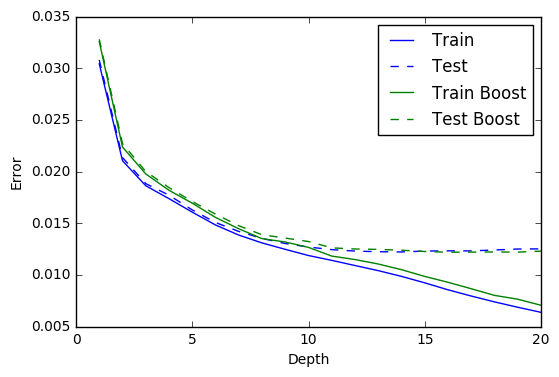

In [90]:
plt.plot(range(1,21), e_train, '-', c = 'blue', label='Train')
plt.plot(range(1,21), e_test, '--', c = 'blue', label='Test')

plt.plot(range(1,21), e_train_b, '-', c = 'green', label='Train Boost')
plt.plot(range(1,21), e_test_b, '--', c = 'green', label='Test Boost')

plt.legend()
plt.xlabel("Depth")
plt.ylabel("Error")

In [213]:
print "Best random forest fit with boost\n---------------------\n Train Error = {0:.05f}\n Test Error = {1:.05f}\n At depth {2}".format(e_train_b[np.argmin(e_test_b)], np.min(e_test_b), range(1,20)[np.argmin(e_test_b)])


Best random forest fit with boost
---------------------
 Train Error = 0.00928
 Test Error = 0.01218
 At depth 16


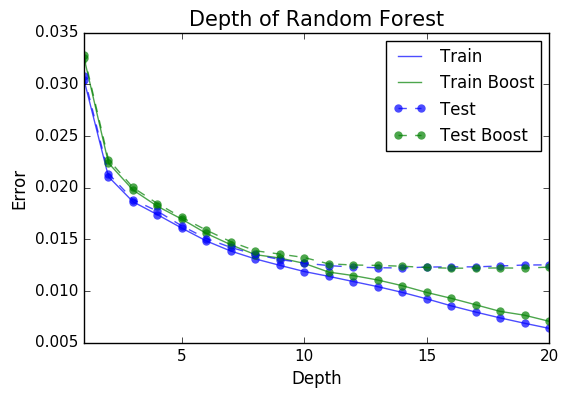

In [155]:
# Plot the results with wand without boosting


ax = df_rf[['Depth', 'Train', 'Train Boost']].plot(x='Depth', marker='o', color = ['blue', 'green'], ls='-', alpha=0.7, markeredgewidth=0)
df_rf[['Depth', 'Test', 'Test Boost']].plot(x='Depth', marker='o', color = ['blue', 'green'], ls='--', alpha=0.7, markeredgewidth=0, ax=ax, fontsize=11)

plt.title('Depth of Random Forest', size = 15)
plt.ylabel('Error',size = 12)
plt.xlabel('Depth',size = 12)

plt.savefig(root + 'Plots/RF.pdf',format='pdf')